YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/var/folders/cw/96xhlzx15sqfhhl1jnx1whr40000gp/T/ipykernel_1854/1078467493.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'][buy_condition] = 1
/var/folders/cw/96xhlzx15sqfhhl1jnx1whr40000gp/T/ipykernel_1854/1078467493.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'][buy_condition] = 1
/var/folders/cw/96xhlzx15sqfhh

Performance Metrics:
- NVDA:
  Total Strategy Return: 0.00%
  Total Buy and Hold Return: 2201.97%
- PLTR:
  Total Strategy Return: 0.00%
  Total Buy and Hold Return: 712.42%
- SPY:
  Total Strategy Return: 0.00%
  Total Buy and Hold Return: 95.30%
- AMZN:
  Total Strategy Return: 0.00%
  Total Buy and Hold Return: 133.19%


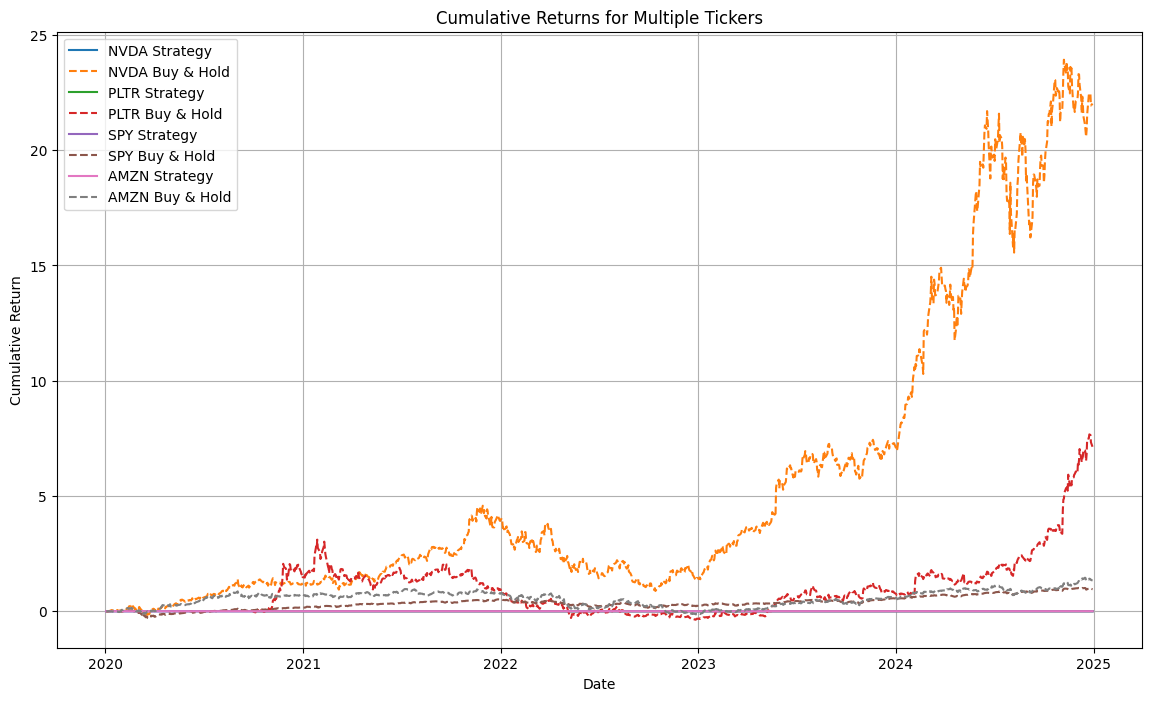

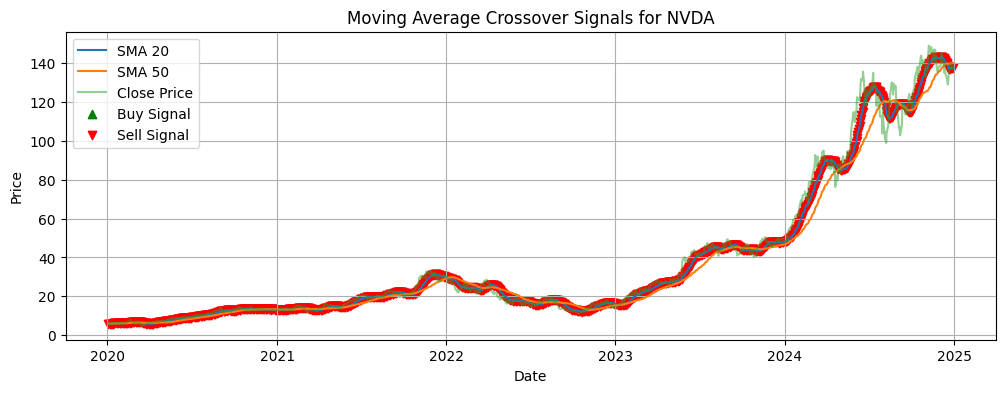

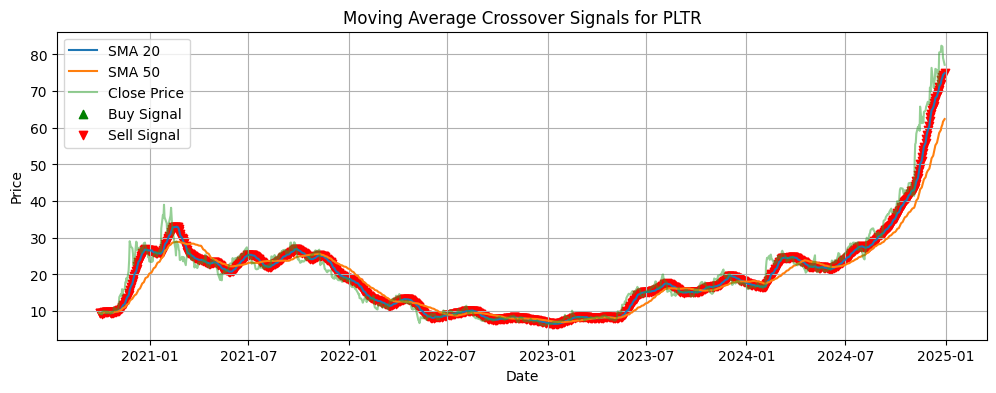

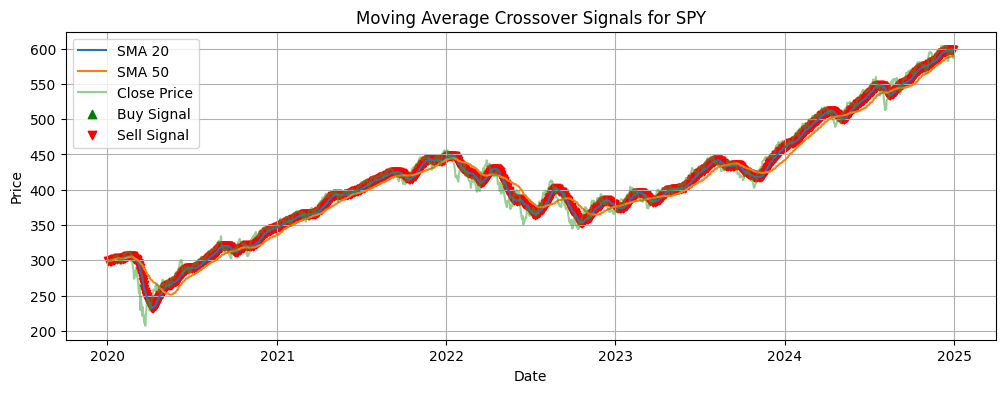

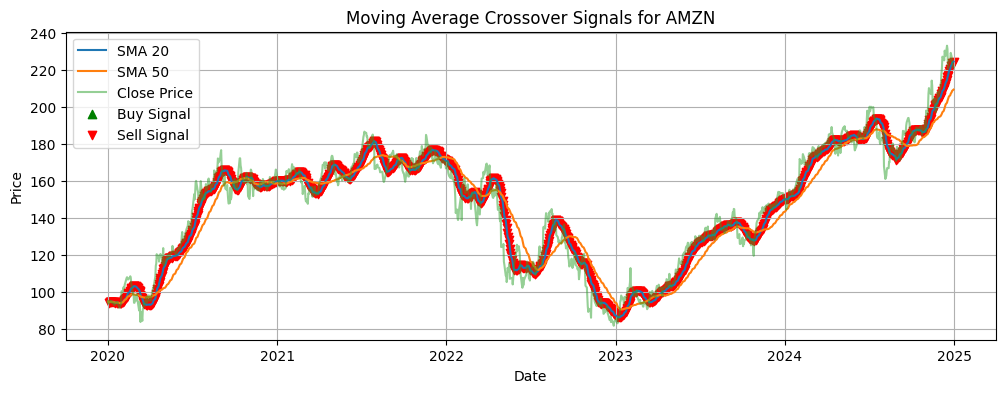

In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

def get_data(tickers, start_date, end_date):
    """Downloads historical price data for multiple tickers using yfinance."""
    data = {}
    for ticker in tickers:
        df = yf.download(ticker, start=start_date, end=end_date)
        if not df.empty:
            data[ticker] = df
        else:
            print(f"Could not retrieve data for {ticker} between {start_date} and {end_date}.")
    return data

def calculate_moving_averages(data, short_window, long_window):
    """Calculates short-term and long-term simple moving averages for each ticker."""
    for ticker, df in data.items():
        df['SMA_short'] = df['Close'].rolling(window=short_window, min_periods=1).mean()
        df['SMA_long'] = df['Close'].rolling(window=long_window, min_periods=1).mean()
    return data

def generate_signals(data):
    """Generates buy and sell signals for each ticker."""
    for ticker, df in data.items():
        df['Signal'] = 0
        buy_condition = (df['SMA_short'].shift(1) <= df['SMA_long'].shift(1)) & (df['SMA_short'] > df['SMA_long'])
        sell_condition = (df['SMA_short'].shift(1) >= df['SMA_long'].shift(1)) & (df['SMA_short'] < df['SMA_long'])
        df['Signal'][buy_condition] = 1
        df['Signal'][sell_condition] = 0
        df['Position'] = df['Signal'].ffill()
    return data

def calculate_returns(data):
    """Calculates asset and strategy returns for each ticker."""
    for ticker, df in data.items():
        df['Asset_Return'] = df['Close'].pct_change()
        df['Strategy_Return'] = df['Position'].shift(1) * df['Asset_Return']
        df['Cumulative_Asset_Return'] = (1 + df['Asset_Return']).cumprod() - 1
        df['Cumulative_Strategy_Return'] = (1 + df['Strategy_Return']).cumprod() - 1
    return data

def evaluate_performance(data):
    """Prints basic performance metrics for each ticker."""
    print("Performance Metrics:")
    for ticker, df in data.items():
        if not df.empty and 'Cumulative_Strategy_Return' in df.columns and 'Cumulative_Asset_Return' in df.columns:
            total_strategy_return = df['Cumulative_Strategy_Return'].iloc[-1]
            total_asset_return = df['Cumulative_Asset_Return'].iloc[-1]
            print(f"- {ticker}:")
            print(f"  Total Strategy Return: {total_strategy_return:.2%}")
            print(f"  Total Buy and Hold Return: {total_asset_return:.2%}")
        else:
            print(f"- {ticker}: Could not calculate performance metrics due to missing data.")

def visualize_cumulative_returns(data):
    """Plots cumulative returns for all tickers in a single figure."""
    plt.figure(figsize=(14, 8))
    for ticker, df in data.items():
        if not df.empty and 'Cumulative_Strategy_Return' in df.columns and 'Cumulative_Asset_Return' in df.columns:
            plt.plot(df.index, df['Cumulative_Strategy_Return'], label=f'{ticker} Strategy')
            plt.plot(df.index, df['Cumulative_Asset_Return'], label=f'{ticker} Buy & Hold', linestyle='--')
    plt.title('Cumulative Returns for Multiple Tickers')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.show()

def visualize_signals_separate(data, short_window, long_window):
    """Plots price and moving averages with signals for each ticker in separate figures."""
    for ticker, df in data.items():
        if not df.empty and 'SMA_short' in df.columns and 'SMA_long' in df.columns and 'Close' in df.columns and 'Signal' in df.columns:
            plt.figure(figsize=(12, 4))
            plt.plot(df.index, df['SMA_short'], label=f'SMA {short_window}')
            plt.plot(df.index, df['SMA_long'], label=f'SMA {long_window}')
            plt.plot(df.index, df['Close'], label='Close Price', alpha=0.5)
            buy_signals = df[df['Signal'] == 1]
            sell_signals = df[df['Signal'] == 0].iloc[1:]
            plt.scatter(buy_signals.index, buy_signals['SMA_short'], marker='^', color='g', label='Buy Signal')
            plt.scatter(sell_signals.index, sell_signals['SMA_short'], marker='v', color='r', label='Sell Signal')
            plt.title(f'Moving Average Crossover Signals for {ticker}')
            plt.xlabel('Date')
            plt.ylabel('Price')
            plt.legend()
            plt.grid(True)
            plt.show()
        else:
            print(f"Could not visualize signals for {ticker} due to missing data.")

if __name__ == "__main__":
    # Strategy Parameters
    tickers = ["NVDA", "PLTR", "SPY", "AMZN"]  # List of tickers to backtest
    start_date = "2020-01-01"
    end_date = "2024-12-31"
    short_window = 20
    long_window = 50

    # Backtesting Process
    all_data = get_data(tickers, start_date, end_date)

    if all_data:
        processed_data = calculate_moving_averages(all_data, short_window, long_window)
        processed_data = generate_signals(processed_data)
        processed_data = calculate_returns(processed_data)
        evaluate_performance(processed_data)
        visualize_cumulative_returns(processed_data)
        visualize_signals_separate(processed_data, short_window, long_window)
    else:
        print("No data retrieved for any of the specified tickers.")